# COVID-19 World statistics

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import date, timedelta
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

First let's define a function to download the latest data available from the European Centre for Disease Prevention and Control.

In [8]:
def loadData():
    try:
        url = "https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx"
        df = pd.read_excel(url)
    except:
        raise SystemExit("\nImpossible to retrieve data. The ECDC server may be down.\n")
        
    df = df.rename(columns = {'dateRep':'DateRep','cases':'Cases','deaths':'Deaths','countriesAndTerritories':'Countries and territories','popData2018':'Population'}) 
    df['DateRep']= pd.to_datetime(df['DateRep'])
    day = df.groupby('DateRep').any().index[-1]    
    Pop = df.groupby('Countries and territories').first()['Population']
    Pop.loc['Cases_on_an_international_conveyance_Japan'] = 1000000000000
    
    print('Last updated data:\t%s' %day.strftime("%d-%m-%Y"))
    return df, Pop

We will also define the functions to compute the MACD indicator (see [Readme](https://github.com/Inami13/COVID-19/blob/master/README.md) for more details).

In [9]:
def computeMACD(values, short, long, lag):
    macd   = computeEMA(values, short) - computeEMA(values, long)
    signal = computeEMA(macd, lag)
    hist   = macd - signal
    return macd, signal, hist

def computeEMA(values, period):    
    return values.ewm(span=period,min_periods=0,adjust=False,ignore_na=False).mean()

Now we will define the main blocks of the code.

In [10]:
def CountryMACD(Country, short=14, long=21, lag=9):
    df = loadData()[0]
    data = df[df['Countries and territories'] == Country][['DateRep','Cases','Deaths']]
    data = data.iloc[::-1]
    v = [data.Cases,data.Deaths]
    xaxis = data.DateRep
    for i in range(len(v)):
        macd,signal,hist = computeMACD(v[i], short, long, lag)     # (12,26,9) is common in trading        
                
        fig = plt.figure(i+1,figsize=(20,20))
    
        ax = fig.add_subplot(211)
        ax.plot(xaxis, v[i], color='black', linewidth=2, label = 'New %s per day'%v[i].name)
        ax.plot(xaxis, computeEMA(v[i], short), color='r', linewidth=1, label = 'EMA %d days'%short)
        ax.plot(xaxis, computeEMA(v[i], long), color='g', linewidth=1, label = 'EMA %d days'%long)
        ax.grid()
        ax.legend()
        plt.title('New %s in %s per day'%(v[i].name,Country))
        
        ax2 = fig.add_subplot(212)
        ax2.plot(xaxis, macd,   color='orange', linewidth=1, label = 'MACD')
        ax2.plot(xaxis, signal, color='steelblue', linewidth=1, label = 'Signal Line')
            
        hist = np.array(hist)
        negInc = np.logical_and(hist < 0, np.concatenate([[False], hist[1:] < hist[:-1]], axis=0))
        negDec = np.logical_and(hist < 0, np.concatenate([[False], hist[1:] >= hist[:-1]], axis=0))
        posInc = np.logical_and(hist >= 0, np.concatenate([[False], hist[1:] > hist[:-1]], axis=0))
        posDec = np.logical_and(hist >= 0, np.concatenate([[False], hist[1:] <= hist[:-1]], axis=0))
        
        ax2.bar (xaxis[negInc], hist[negInc], width=1, align='edge', color=(0,0.8,0))
        ax2.bar (xaxis[negDec], hist[negDec], width=1, align='edge', color=(0.5,0.8,0.5))
        ax2.bar (xaxis[posInc], hist[posInc], width=1, align='edge', color=(0.8,0,0))
        ax2.bar (xaxis[posDec], hist[posDec], width=1, align='edge', color=(0.8,0.5,0.5))         
        ax2.grid()
        ax2.legend()
        
def WorldMetrics(span = 14, Acc_mode = 'MACD'):
    # span = timespan in days for the computation of the acceleration
    # Acc_mode = acceleration computation: MACD for Moving Average Convergence Divergence, 
    #           SMA for Simple Moving Average or EMA for Exponential Moving Average. Else
    #           for computing a direct acceleration without smoothing the data.
    
    df, Pop = loadData()
   
    print("\n___________________________________________\n")
    print('TOTAL CASES:\t %d'%df[['Cases']].sum())
    print('TOTAL DEATHS:\t %d'%df[['Deaths']].sum())
    print("___________________________________________\n")
    
    C = df.groupby('Countries and territories')['Cases'].agg(["sum","first"]).rename_axis([""])
    C = C.rename(columns={"sum":"Total","first":"New"}, index={'CANADA':'Canada'})
    C = pd.concat([C, Pop.reindex(C.index)], axis=1, sort=True)
    C = C.sort_values(by='Total', ascending = False)
        
    print("Top 10 Countries in detected cases")
    print("-------------------------------------------\n")    
    print(C.head(10)[['Total','New']])
    print("-------------------------------------------\n")
    
    C10 = C.index[0:10]
    
    C['Cases / 100000 ppl'] = C['Total'] / C['Population'] * 100000
    C = C.sort_values(by='Cases / 100000 ppl', ascending = False)
    C['Cases / 100000 ppl'] = C['Cases / 100000 ppl'].map('{:.1f}'.format)
    
    print("Top 10 Countries in cases / 100000 people")
    print("-------------------------------------------\n")
    print(C.head(10)[['Cases / 100000 ppl']])
    print("___________________________________________\n")
    
    fig1 = plt.figure(1,figsize=(20,10))
    ax1 = fig1.add_subplot(111)
    ax1.set_title('Cumulative cases')
    ax1.grid(which='both')
    
    fig2 = plt.figure(2,figsize=(20,20))    
    ax21 = fig2.add_subplot(211)
    ax21.set_title('New cases')
    ax21.grid()
    
    ax22 = fig2.add_subplot(212)
    ax22.set_title('New cases (EMA %d days)'%span)
    ax22.grid()
    
    fig3 = plt.figure(3,figsize=(20,10))
    ax3 = fig3.add_subplot(111)
    ax3.set_title('Acceleration in new cases')
    ax3.grid()
    
    fig7 = plt.figure(7,figsize=(20,10))
    ax7 = fig7.add_subplot(111)
    ax7.loglog()
    ax7.set_title('New vs Total (EMA 7 days)')
    ax7.grid(b=True, which='major', color='black')
    ax7.grid(b=True, which='minor', color='grey', linestyle=':')
    ax7.set_xlabel('Total cases')
    ax7.set_ylabel('New cases')
    
    for ele in C10:
        c = df[df['Countries and territories'] == ele][['DateRep','Cases']].iloc[::-1]
        c['Cumulative'] = c['Cases'].cumsum()
        c['Acceleration'] = c['Cases'].diff()

        ax1.plot(c.DateRep,c.Cumulative,label = ele)
        
        ax21.plot(c.DateRep,c.Cases,label = ele)        
        ax22.plot(c.DateRep,c.Cases.ewm(span = span,adjust = False).mean(),label = ele)        
        
        if Acc_mode == 'EMA':
            ax3.plot(c.DateRep,c.Acceleration.ewm(span = span,adjust = False).mean(),label = ele)
        elif Acc_mode == 'SMA':
            ax3.plot(c.DateRep,c.Acceleration.rolling(window = span).mean(),label = ele)
        elif Acc_mode == 'MACD':
            hist = computeMACD(c.Cases, 14, 21, 9)[2]  # (12,26,9) is common in trading        
            ax3.plot(c.DateRep,hist,label = ele)
        else:
            ax3.plot(c.DateRep,c.Acceleration,label = ele)
        
        ax7.plot(c.Cumulative.ewm(span = 7,adjust = False).mean(), c.Cases.ewm(span = 7,adjust = False).mean(), label = ele)
       
    ax1.legend()
    ax21.legend()
    ax3.legend()
    ax7.legend()
    ax7.set_xlim(left=5)
    ax7.set_ylim(bottom=5)
        
    D = df.groupby('Countries and territories')['Deaths'].agg(["sum","first"]).rename_axis([""])
    D = D.rename(columns={"sum":"Total","first":"New"}, index={'CANADA':'Canada'})
    D = pd.concat([D, Pop.reindex(C.index)], axis=1, sort=True)
    D = D.sort_values(by='Total', ascending = False)
        
    print("Top 10 Countries in deaths")
    print("-------------------------------------------\n")
    print(D.head(10)[['Total','New']])
    print("-------------------------------------------\n")
    
    D10 = D.index[0:10]
    
    D['Deaths / 100000 ppl'] = D['Total'] / D['Population'] * 100000
    D = D.sort_values(by='Deaths / 100000 ppl', ascending = False)
    D['Deaths / 100000 ppl'] = D['Deaths / 100000 ppl'].map('{:.1f}'.format)
    
    print("Top 10 Countries in deaths / 100000 people")
    print("-------------------------------------------\n")    
    print(D.head(10)[['Deaths / 100000 ppl']])
    print("___________________________________________\n")
    
    fig4 = plt.figure(4,figsize=(20,10))
    ax4 = fig4.add_subplot(111)
    ax4.set_title('Cumulative deaths')
    ax4.grid(which='both')
    
    fig5 = plt.figure(5,figsize=(20,20))    
    ax51 = fig5.add_subplot(211)
    ax51.set_title('New deaths')
    ax51.grid()
    
    ax52 = fig5.add_subplot(212)
    ax52.set_title('New deaths (EMA %d days)'%span)
    ax52.grid()
    
    fig6 = plt.figure(6,figsize=(20,10))
    ax6 = fig6.add_subplot(111)
    ax6.set_title('Acceleration in new deaths')
    ax6.grid()
    
    fig8 = plt.figure(8,figsize=(20,10))
    ax8 = fig8.add_subplot(111)
    ax8.loglog()
    ax8.set_title('New vs Total (EMA 7 days)')
    ax8.grid(b=True, which='major', color='black')
    ax8.grid(b=True, which='minor', color='grey', linestyle=':')
    ax8.set_xlabel('Total deaths')
    ax8.set_ylabel('New deaths')
    
    for ele in D10:
        d = df[df['Countries and territories'] == ele][['DateRep','Deaths']].iloc[::-1]
        d['Cumulative'] = d['Deaths'].cumsum()
        d['Acceleration'] = d['Deaths'].diff()

        ax4.plot(d.DateRep,d.Cumulative,label = ele)
        
        ax51.plot(d.DateRep,d.Deaths,label = ele)
        ax52.plot(d.DateRep,d.Deaths.ewm(span = span,adjust = False).mean(),label = ele)
        
        if Acc_mode == 'EMA':
            ax6.plot(d.DateRep,d.Acceleration.ewm(span = span,adjust = False).mean(),label = ele)
        elif Acc_mode == 'SMA':
            ax6.plot(d.DateRep,d.Acceleration.rolling(window = span).mean(),label = ele)
        elif Acc_mode == 'MACD':
            hist = computeMACD(d.Deaths, 14, 21, 9)[2]  # (12,26,9) is common in trading        
            ax6.plot(d.DateRep,hist,label = ele)
        else:
            ax6.plot(d.DateRep,d.Acceleration,label = ele)
        
        ax8.plot(d.Cumulative.ewm(span = 7,adjust = False).mean(), d.Deaths.ewm(span = 7,adjust = False).mean(), label = ele)     
    
    ax4.legend()
    ax51.legend()
    ax6.legend()
    ax8.legend()
    ax8.set_xlim(left=5)
    ax8.set_ylim(bottom=5)
        

The first one *CountryMACD* will compute the MACD for each specific country and return the coresponding plots. Note that countries must be given identical to the Dataframe labels in the column _Countries and territories_.

Let's see an example for the case of China:

Last updated data:	07-04-2020


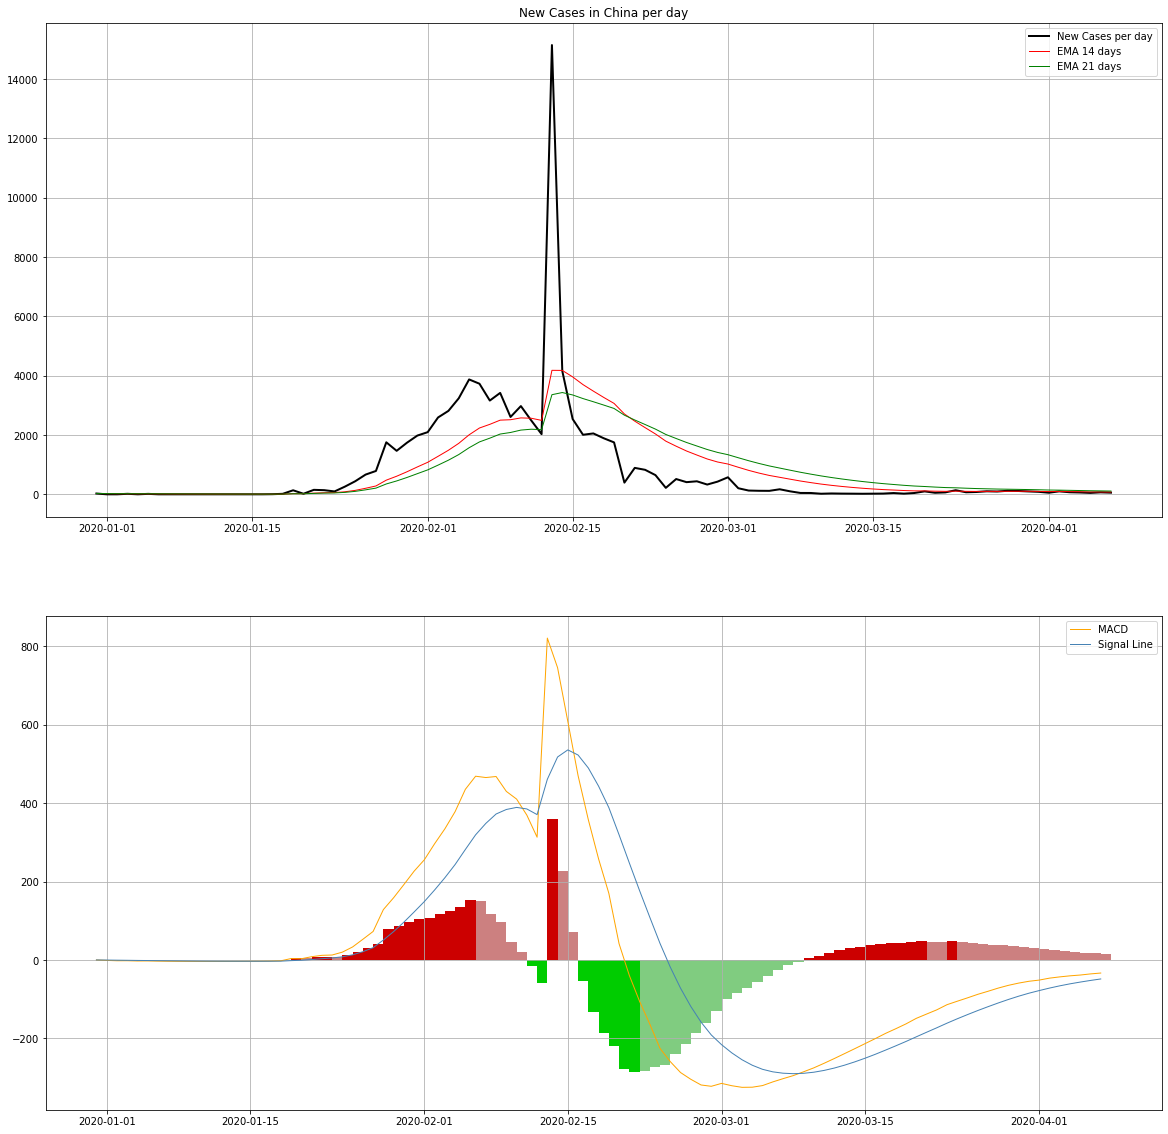

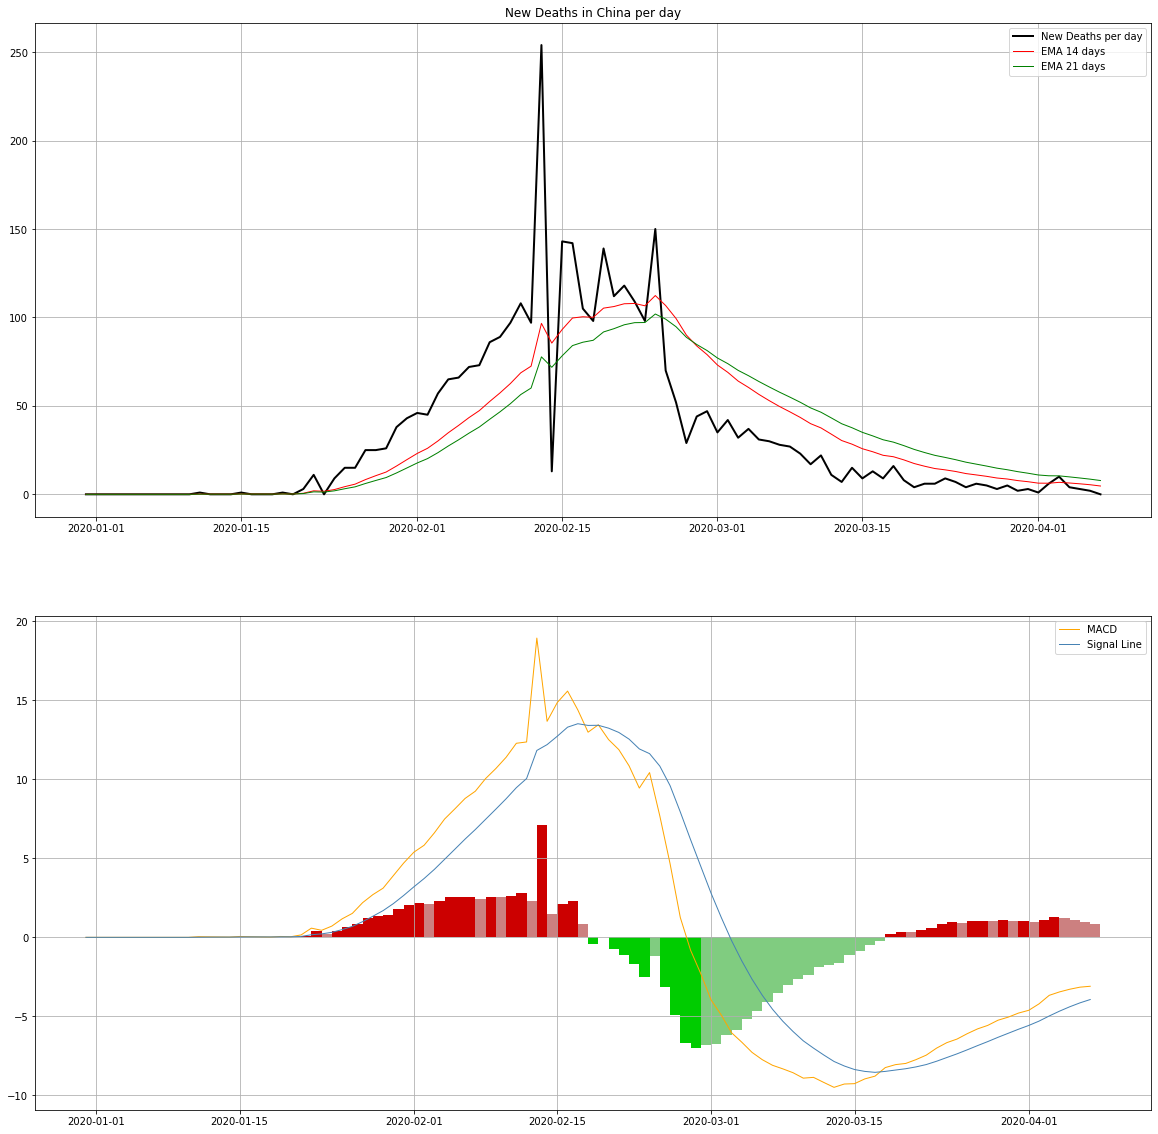

In [11]:
CountryMACD('China')

The second one *WorldMetrics* will classify countries in terms of:

 * Cases
 * Cases normalized by population
 * Deaths
 * Deaths normalized by population
 
Some plots show the chronological evolution of the disease for the top 10 countries. New cases and deaths are smoothed using an Exponential Moving Average of 14 days, i.e. the maximum incubation time of the COVID-19.

Last updated data:	07-04-2020

___________________________________________

TOTAL CASES:	 1316988
TOTAL DEATHS:	 74066
___________________________________________

Top 10 Countries in detected cases
-------------------------------------------

                           Total    New
                                       
United_States_of_America  368196  30561
Spain                     135032   4273
Italy                     132547   3599
Germany                    99225   3834
China                      82698     56
France                     74390   3912
Iran                       60500   2274
United_Kingdom             51608   3802
Turkey                     30217   3148
Switzerland                21574    552
-------------------------------------------

Top 10 Countries in cases / 100000 people
-------------------------------------------

              Cases / 100000 ppl
                                
San_Marino                 819.9
Holy_See                   700.0
Andorra     

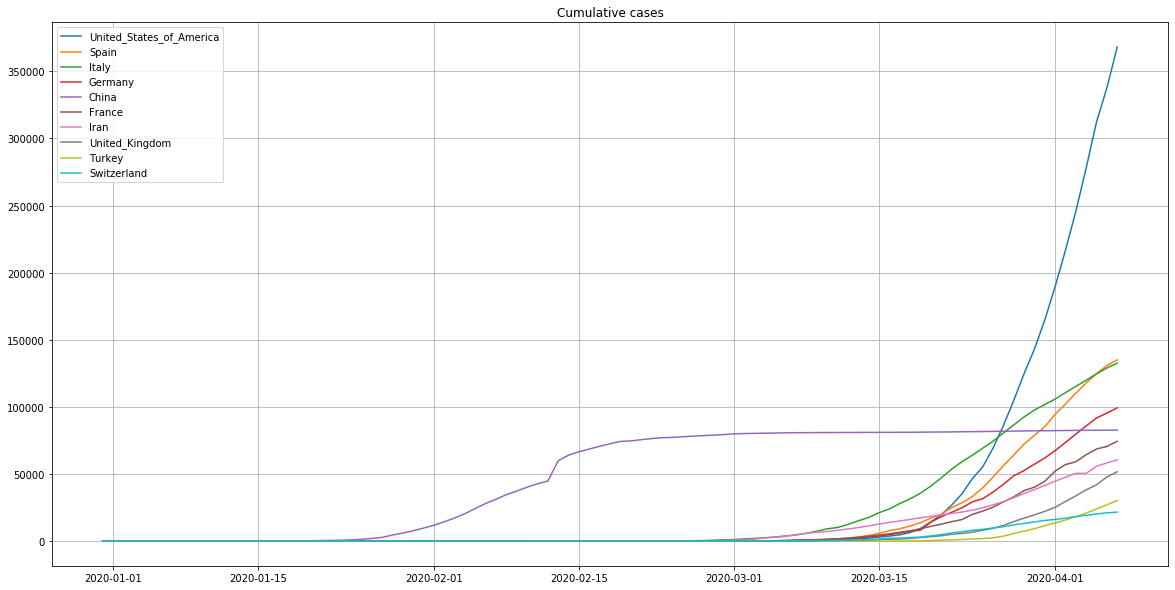

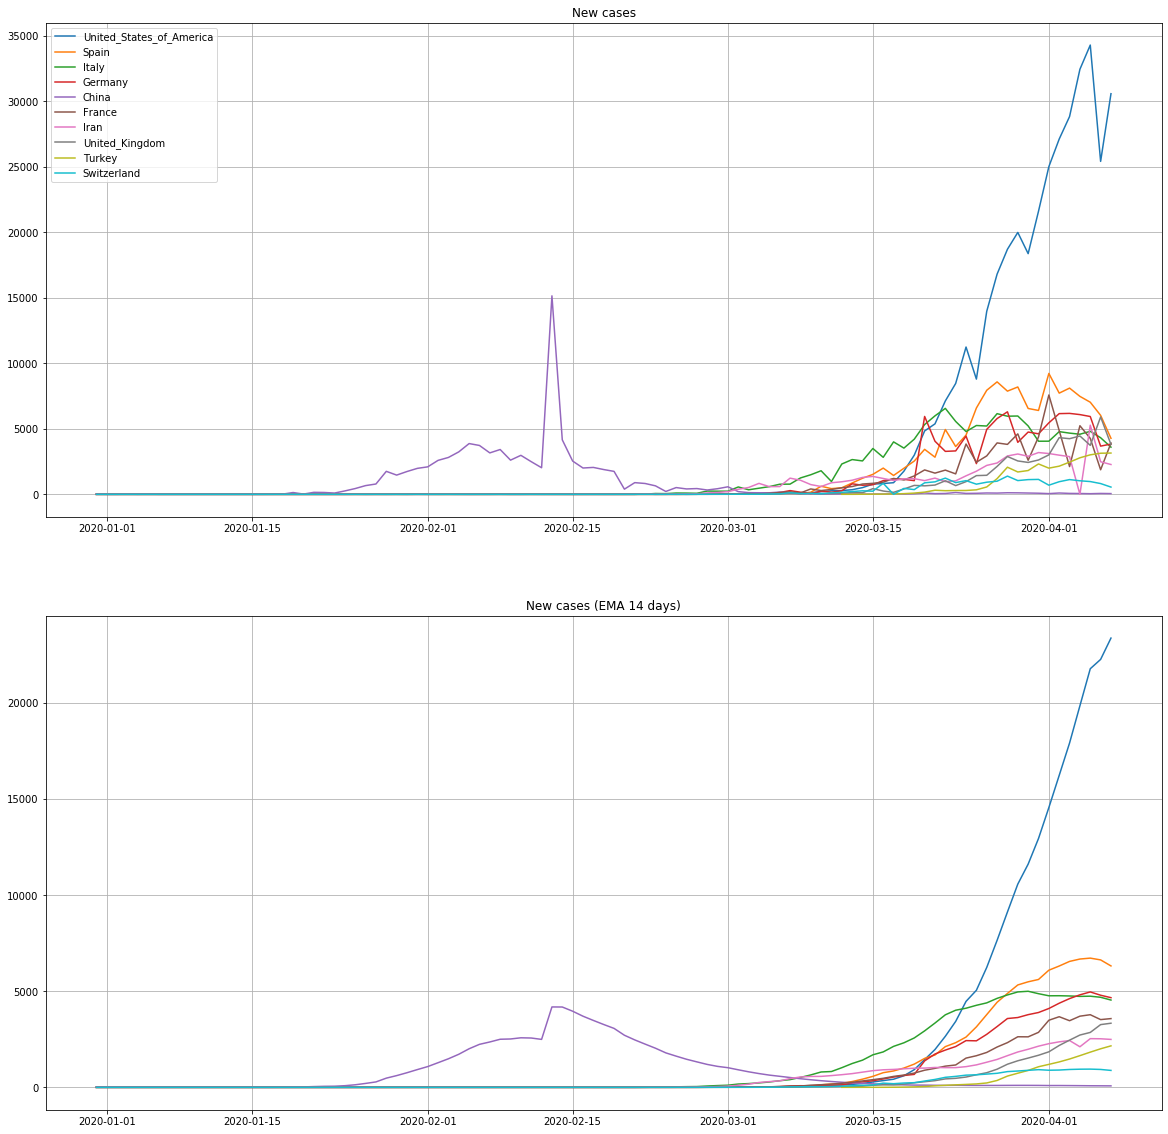

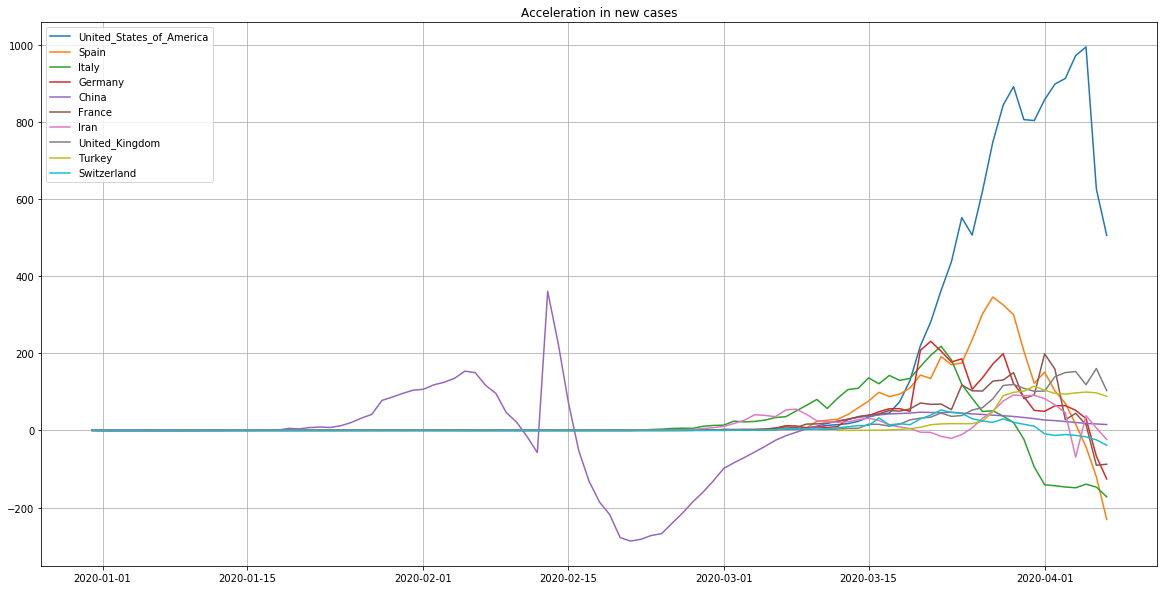

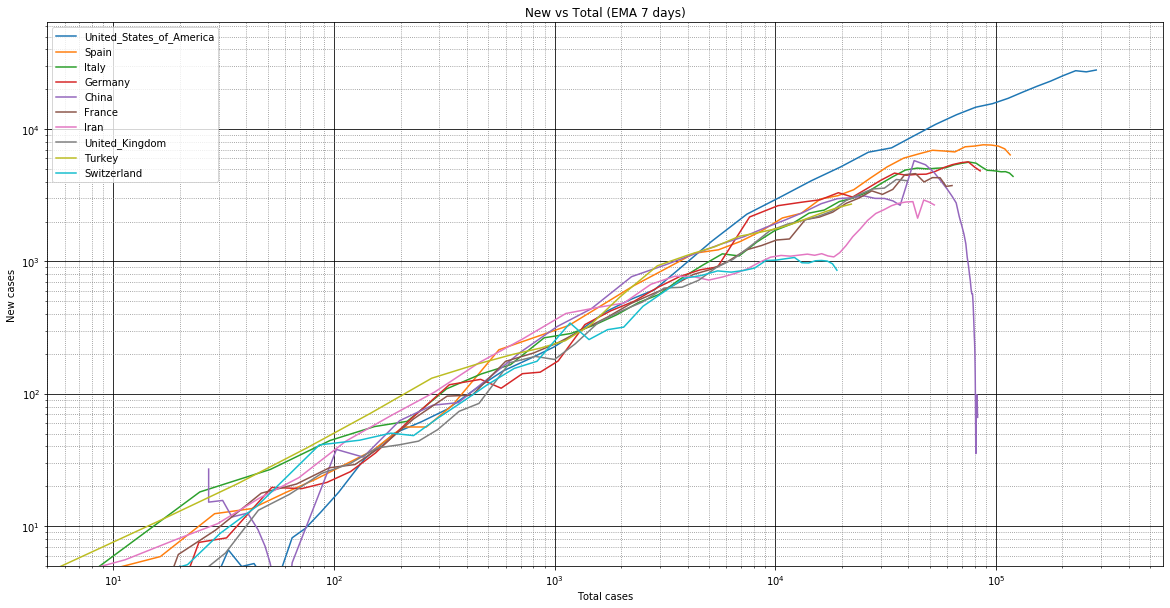

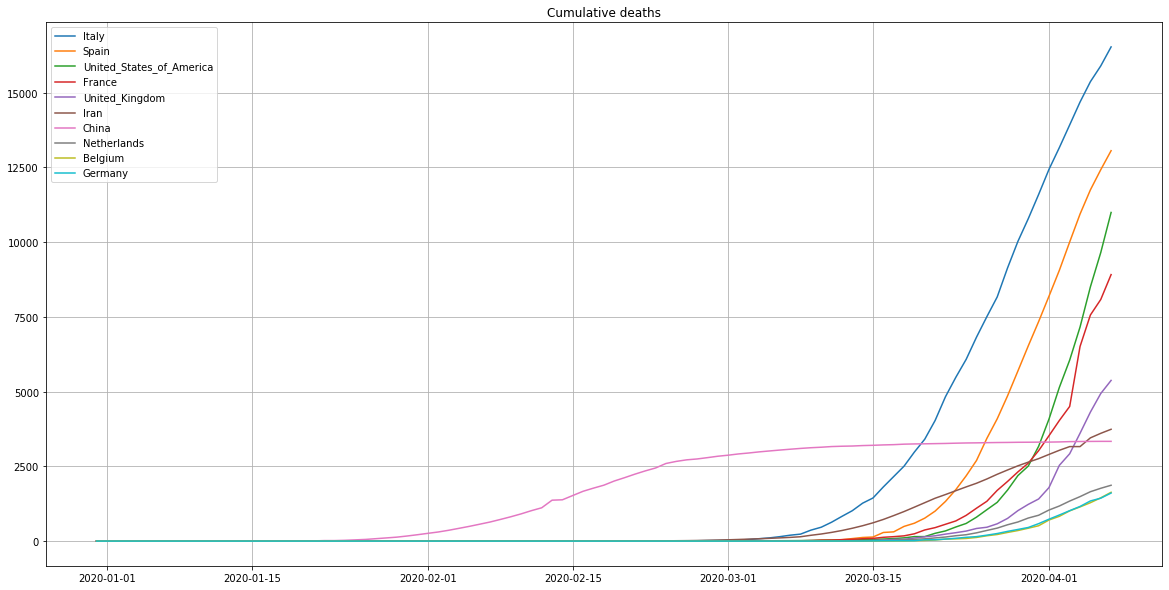

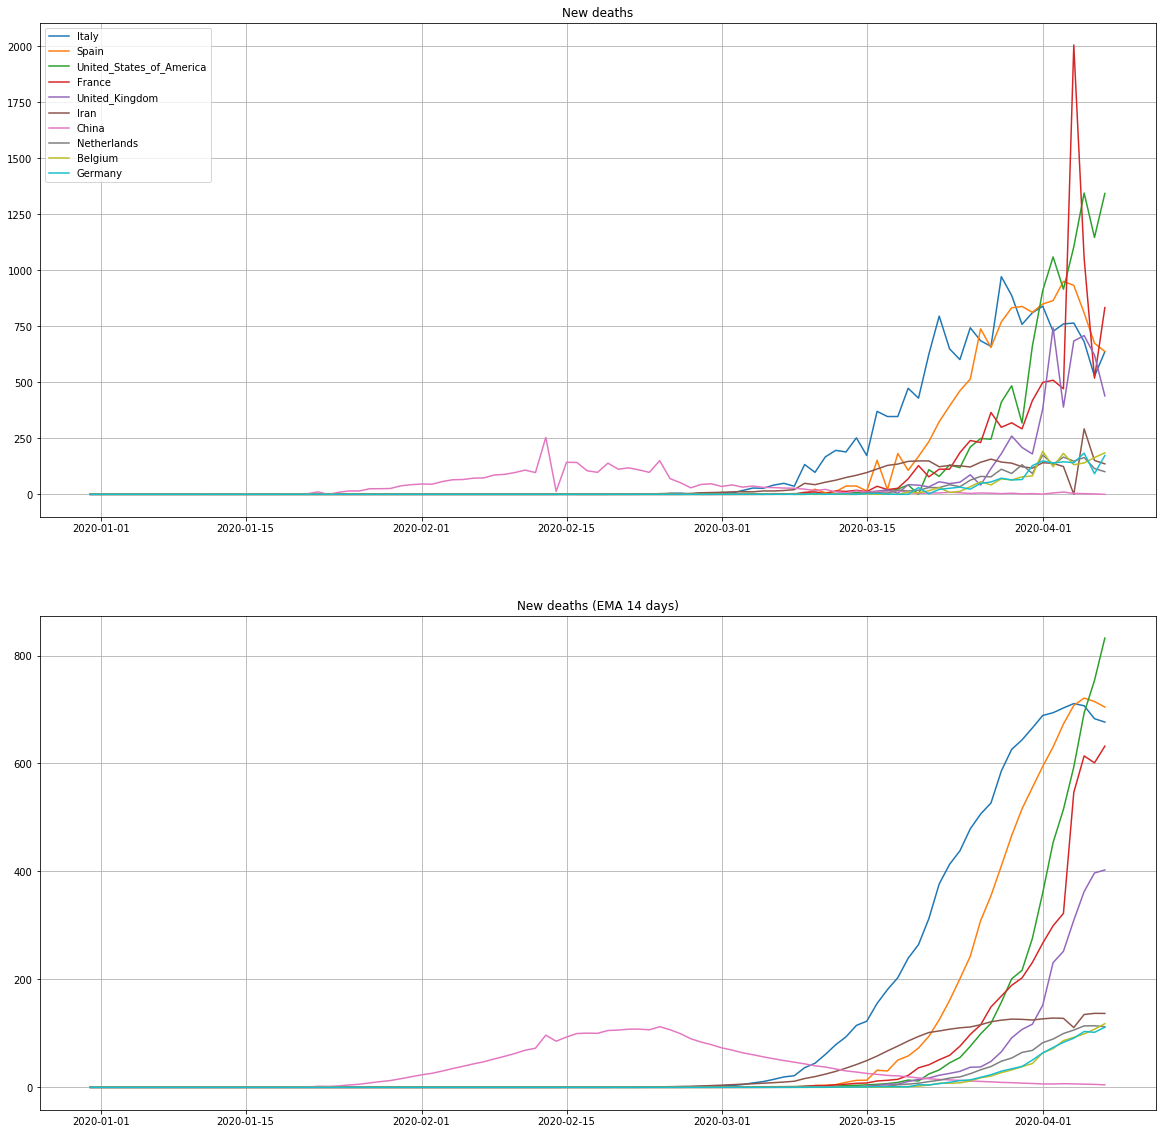

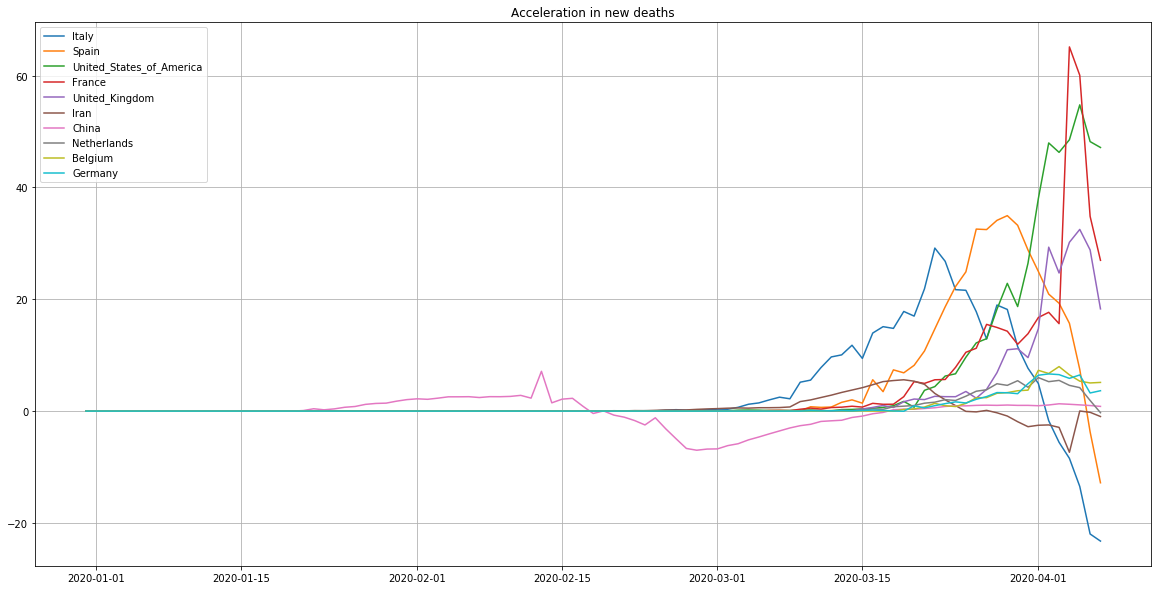

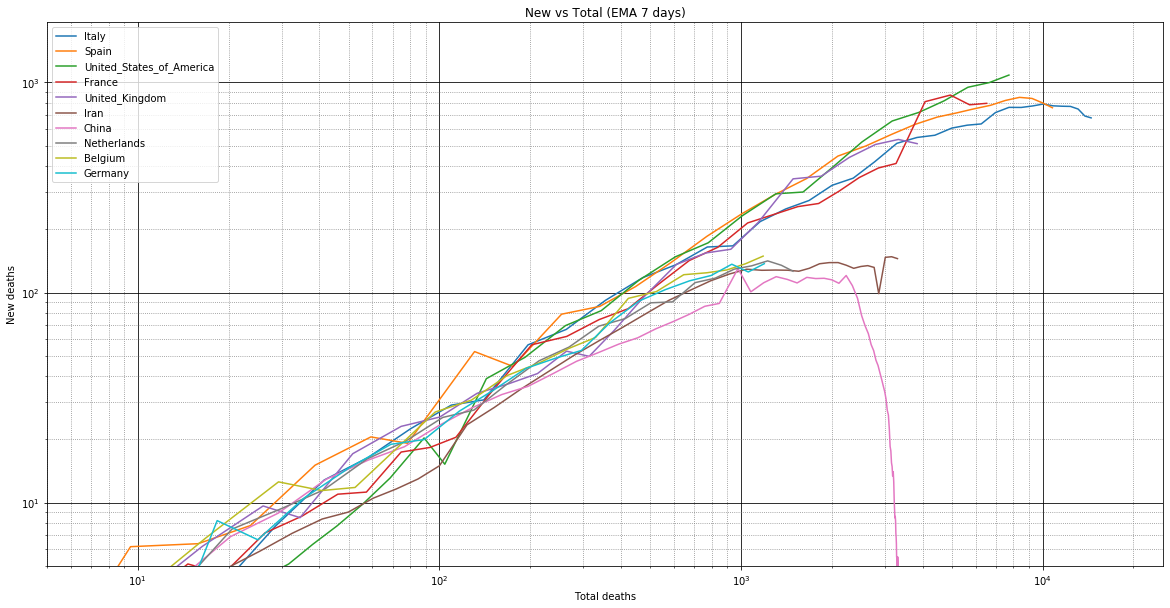

In [12]:
WorldMetrics()